## Importing packages

In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random
import math
import copy

# package(s) related to the simulation
import simpy
import networkx as nx  
import numpy as np
import pandas as pd
import yaml as yaml
import matplotlib.pyplot as plt
import matplotlib as mpl
import bisect
from matplotlib.ticker import MaxNLocator

# OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model
from opentnsim import lock
from opentnsim import vessel
from opentnsim import import_hydrodynamic_dataset

# spatial libraries 
import shapely.geometry
import shapely.wkt
import pyproj
import shapely.geometry
import folium

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate system
geod = pyproj.Geod(ellps="WGS84")

location_vessel_database = "Vessels/richtlijnen-vaarwegen-2017.csv"

## Creating a network

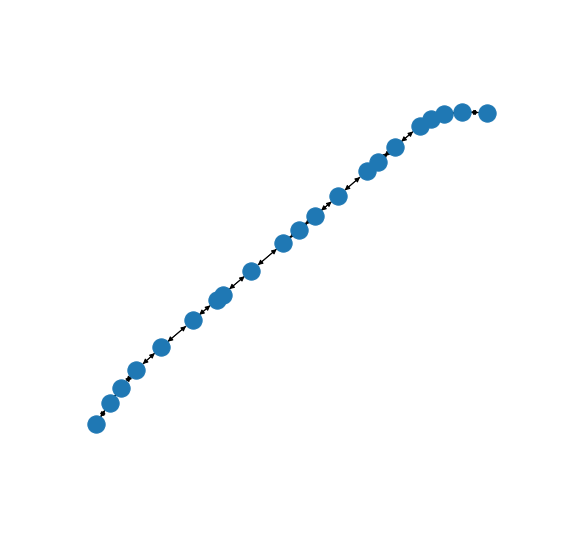

In [2]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
nodes = []
path = []

coords = [[4.431711765453108,51.69919249464677],
          [4.428674043520671,51.69925058643445],
          [4.426520307378901,51.69909734687116],
          [4.424980827084277,51.69876203857485],
          [4.423697201845156,51.69822379606292],
          [4.42074464145006,51.69663454747826],
          [4.418738102576006,51.69556033504191],
          [4.417414946619205,51.69484342434918],
          [4.414052050039478,51.69302665557799],
          [4.411260559026335,51.69152063195392],
          [4.409375907761905,51.69049721074719],
          [4.407558470987929,51.68950444222966],
          [4.403773394426889,51.68748639488896],
          [4.400388700536705,51.68570503952014],
          [4.399705360113479,51.68532707785089],
          [4.396838866281541,51.68379266841475],
          [4.393109213885338,51.68180281425153],
          [4.390189828820366,51.68013249657422],
          [4.388336842048544,51.67879411774161],
          [4.387028491268927,51.6776897747193],
          [4.385381824047309,51.67609098108045]]

for d in range(len(coords)):
    data_node = {"env": [],
                 "name": "Node " + str(d+1),
                 "geometry": shapely.geometry.Point(coords[d][0], coords[d][1])}
    node = Node(**data_node)
    nodes.append(node)

for i in range(2):
    if i == 0:
        for j in range(len(nodes)-1):
            path.append([nodes[j], nodes[j+1]])
    if i == 1:
        for j in range(len(nodes)-1):
            path.append([nodes[j+1], nodes[j]])
    
FG = nx.DiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(FG, positions,ax=ax)
plt.show()

## Setting up the simulation

In [3]:
simulation_start = datetime.datetime.now()
sim = model.Simulation(simulation_start,FG)
env = sim.environment
duration = 14*45000#*14*2

In [4]:
depth = [[],[]]
width = [[],[]]
MBL = [[],[]]
water_level=[[],[]]
salinity =[[],[]]

for nodes in enumerate(FG.nodes):
    MBL[0].append(FG.nodes[nodes[1]]['geometry'])
    width[0].append(FG.nodes[nodes[1]]['geometry'])
    depth[0].append((FG.nodes[nodes[1]]['geometry']))
    water_level[0].append((FG.nodes[nodes[1]]['geometry']))
    water_level[1].append([[],[]])
    salinity[0].append((FG.nodes[nodes[1]]['geometry']))
    salinity[1].append([[],[]])

MBL[1] = [5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5]
depth[1] = MBL[1]
width[1] = [200,200,200,200,300,300,300,200,200,25,25,25,200,200,300,300,300,200,200,200,200]
times = np.arange(simulation_start.timestamp(),(simulation_start+datetime.timedelta(seconds=duration)).timestamp(),60)

for node in enumerate(list(FG.nodes)):
    if node[0] <= 10:
        water_level[1][node[0]][0]=times
        water_level[1][node[0]][1]=[1.25*np.sin(2*np.pi*(t-simulation_start.timestamp())/45000)+2.5 for t in times]
        salinity[1][node[0]][0]=times
        salinity[1][node[0]][1]=[25 for t in times]
    else:
        water_level[1][node[0]][0]=times
        water_level[1][node[0]][1]=[2.5 for t in times]
        salinity[1][node[0]][0]=times
        salinity[1][node[0]][1]=[0 for t in times]

In [5]:
wlev_dif = [[],[]]
for i in range(len(water_level[1][0][1])):
    wlev_dif[0].append(water_level[1][0][0][i])
    wlev_dif[1].append(abs(water_level[1][10][1][i]-water_level[1][11][1][i]))

In [6]:
import xarray as xr
time_data = xr.DataArray(data=water_level[1][0][0],
                         dims=["TIME"])

MBL_data = xr.DataArray(data=MBL[1],
                        dims=["NODES"])

width_data = xr.DataArray(data=width[1],
                          dims=["NODES"])

depth_data = xr.DataArray(data=depth[1],
                          dims=["NODES"])

water_level_data = xr.DataArray(data=[wlev[1] for wlev in water_level[1]],
                                dims=["NODES","TIME"])

salinity_data = xr.DataArray(data=[sal[1] for sal in salinity[1]],
                             dims=["NODES","TIME"])

hydrodynamic_data = xr.Dataset({'Times': time_data,
                                'MBL':MBL_data,
                                'Width':width_data,
                                'Depth':depth_data,
                                'Water level': water_level_data,
                                'Salinity':salinity_data})

In [7]:
import_hydrodynamic_dataset.NetworkProperties.append_data_to_nodes(FG,hydrodynamic_data)

## Loading and modifying the vessel database of inland vessel classes

In [8]:
vessel_db = pd.read_csv(location_vessel_database)
vessel_db.columns = ['vessel_id','type','B','L','H_e','H_f','T_e','T_f','C','P']
vessel_db['start_time'] = 0
vessel_db

,vessel_id,type,B,L,H_e,H_f,T_e,T_f,C,P,start_time
0,12ad8a02-4aef-11e9-9940-b469212bff5b,CEMT - I,5.05,38.5,4.65,3.35,1.2,2.5,365,175,0
1,17746aee-4aef-11e9-8ebf-b469212bff5b,CEMT - II,6.60,55.0,5.80,4.60,1.4,2.6,615,250,0
2,1be5fb2e-4aef-11e9-9bfb-b469212bff5b,CEMT - III,8.20,85.0,6.30,5.10,1.5,2.7,1250,435,0
3,208a5aca-4aef-11e9-b7e9-b469212bff5b,CEMT - IV,9.50,105.0,6.70,5.30,1.6,3.0,2040,690,0
4,24f93100-4aef-11e9-8ff9-b469212bff5b,CEMT - Va,11.40,135.0,7.10,5.40,1.8,3.5,3735,1425,0
5,289b8492-4aef-11e9-b34f-b469212bff5b,CEMT - VIa,17.00,135.0,10.00,8.00,2.0,4.0,6000,2015,0


## Creating a vessel generator

In [9]:
Vessel = type('Vessel', 
              (core.Identifiable, lock.HasLineUpArea, lock.HasWaitingArea, lock.HasLock, core.Movable, core.Routeable, vessel.VesselProperties, vessel.ExtraMetadata), {})

generator = model.VesselGenerator(Vessel,vessel_db)

## Defining the infrastructure of the lock

In [10]:
waiting_area_1 = lock.IsLockWaitingArea(env = sim.environment, priority = True, 
                                        name = 'Volkeraksluizen_1', node = "Node 6")

lineup_area_1 = lock.IsLockLineUpArea(env = sim.environment, priority = True, 
                                      name = 'Volkeraksluizen_1', node = "Node 8", lineup_length = 300)

lock_1 = lock.IsLock(env = sim.environment, nr_resources = 100, priority = True, name = 'Volkeraksluizen_1',            
                     node_1 = "Node 10", node_2 = "Node 11", node_3 = "Node 12",
                     lock_length = 300, lock_width = 24, lock_depth = 4.5, 
                     doors_open = 2.5 * 60, doors_close = 2.5 * 60, disch_coeff = 0.8,
                     grav_acc = 9.81, opening_area = 4.0, opening_depth = 5.0,
                     simulation_start = simulation_start)
                                      
waiting_area_2 = lock.IsLockWaitingArea(env = sim.environment, priority = True, 
                                        name = "Volkeraksluizen_1", node = "Node 16")

lineup_area_2 = lock.IsLockLineUpArea(env = sim.environment, priority = True, 
                                        name = "Volkeraksluizen_1", node = "Node 14", lineup_length = 300)

## Appending the infrastructure to the network

In [11]:
#For testing, all locks have the water level at the right side
lock_1.water_level = "Node 10"
FG.nodes["Node 11"]["Lock"] = [lock_1]

FG.nodes["Node 6"]["Waiting area"] = [waiting_area_1]
FG.nodes["Node 8"]["Line-up area"] = [lineup_area_1]

FG.nodes["Node 16"]["Waiting area"] = [waiting_area_2]
FG.nodes["Node 14"]["Line-up area"] = [lineup_area_2] 

In [12]:
vessel_db

,vessel_id,type,B,L,H_e,H_f,T_e,T_f,C,P,start_time
0,12ad8a02-4aef-11e9-9940-b469212bff5b,CEMT - I,5.05,38.5,4.65,3.35,1.2,2.5,365,175,0
1,17746aee-4aef-11e9-8ebf-b469212bff5b,CEMT - II,6.60,55.0,5.80,4.60,1.4,2.6,615,250,0
2,1be5fb2e-4aef-11e9-9bfb-b469212bff5b,CEMT - III,8.20,85.0,6.30,5.10,1.5,2.7,1250,435,0
3,208a5aca-4aef-11e9-b7e9-b469212bff5b,CEMT - IV,9.50,105.0,6.70,5.30,1.6,3.0,2040,690,0
4,24f93100-4aef-11e9-8ff9-b469212bff5b,CEMT - Va,11.40,135.0,7.10,5.40,1.8,3.5,3735,1425,0
5,289b8492-4aef-11e9-b34f-b469212bff5b,CEMT - VIa,17.00,135.0,10.00,8.00,2.0,4.0,6000,2015,0


## Adding the generator to the simulation

In [13]:
origin = 'Node 1' 
destination = 'Node 21'  
env.FG = FG

sim.add_vessels(vessel_generator = generator, origin = origin, destination = destination, arrival_distribution = (3600/5000), arrival_process = 'Uniform',fleet_distribution = [1,1,1,1,1,1])
sim.add_vessels(vessel_generator = generator, origin = destination, destination = origin, arrival_distribution = (3600/5000), arrival_process = 'Uniform',fleet_distribution = [1,1,1,1,1,1])

i = 4
vessel1 = Vessel(name='Vessel 1',
                 geometry=FG.nodes[origin]['geometry'],
                 route=nx.dijkstra_path(FG,origin,destination),
                 env=env,
                 type=vessel_db['type'][i],
                 B = vessel_db['B'][i],
                 L = vessel_db['L'][i],
                 T_f = vessel_db['T_f'][i],
                 T_e = vessel_db['T_e'][i],
                 H_e = vessel_db['H_e'][i],
                 H_f = vessel_db['H_f'][i],
                 C = vessel_db['C'][i],
                 P = vessel_db['P'][i],
                 v = 4,
                 start_time = 0,)
sim.add_vessels(origin,destination,[],vessel1)

i = 3
vessel2 = Vessel(name='Vessel 2',
                 geometry=FG.nodes[origin]['geometry'],
                 route=nx.dijkstra_path(FG,destination,origin),
                 env=env,
                 type=vessel_db['type'][i],
                 B = vessel_db['B'][i],
                 L = vessel_db['L'][i],
                 T_f = vessel_db['T_f'][i],
                 T_e = vessel_db['T_e'][i],
                 H_e = vessel_db['H_e'][i],
                 H_f = vessel_db['H_f'][i],
                 C = vessel_db['C'][i],
                 P = vessel_db['P'][i],
                 v = 4,
                 start_time = 0,)
sim.add_vessels(destination,origin,[],vessel2)

## Run the simulation

In [14]:
sim.run(duration = duration)

c:\users\floorbakker\opentnsim\opentnsim\lock.py:172: RuntimeWarning:

divide by zero encountered in double_scalars

c:\users\floorbakker\opentnsim\opentnsim\lock.py:268: RuntimeWarning:

divide by zero encountered in double_scalars



## Output

In [15]:
vessels = sim.environment.vessels
env = sim.environment

In [16]:
vessels[1].L

105.0

In [17]:
df = pd.DataFrame.from_dict(vessels[2].log)
df

,Message,Timestamp,Value,Geometry
0,Sailing from node Node 1 to node Node 2 start,2022-08-17 17:25:10.000000,[],POINT (4.431711765453108 51.69919249464677)
1,Sailing from node Node 1 to node Node 2 stop,2022-08-17 17:26:02.529862,[],POINT (4.428674043520671 51.69925058643445)
2,Sailing from node Node 2 to node Node 3 start,2022-08-17 17:26:02.529862,[],POINT (4.428674043520671 51.69925058643445)
3,Sailing from node Node 2 to node Node 3 stop,2022-08-17 17:26:39.999030,[],POINT (4.426520307378901 51.69909734687116)
4,Sailing from node Node 3 to node Node 4 start,2022-08-17 17:26:39.999030,[],POINT (4.426520307378901 51.69909734687116)
5,Sailing from node Node 3 to node Node 4 stop,2022-08-17 17:27:08.195312,[],POINT (4.424980827084277 51.69876203857485)
6,Sailing from node Node 4 to node Node 5 start,2022-08-17 17:27:08.195312,[],POINT (4.424980827084277 51.69876203857485)
7,Sailing from node Node 4 to node Node 5 stop,2022-08-17 17:27:34.961059,[],POINT (4.423697201845156 51.69822379606292)
8,Sailing from node Node 5 to node Node 6 start,2022-08-17 17:27:34.961059,[],POINT (4.423697201845156 51.69822379606292)
9,Sailing from node Node 5 to node Node 6 stop,2022-08-17 17:28:42.479286,[],POINT (4.42074464145006 51.69663454747826)


In [18]:
locking_cycle_start_dir1 = simulation_start.timestamp()
locking_cycle_starts_dir1 = []
locking_cycle_stop_dir1 = simulation_start.timestamp()
locking_cycle_stops_dir1 = []
locking_cycle_start_dir2 = simulation_start.timestamp()
locking_cycle_starts_dir2 = []
locking_cycle_stop_dir2 = simulation_start.timestamp()
locking_cycle_stops_dir2 = []

for v in range(0,len(vessels)):
    for t in range(0,len(vessels[v].log["Message"])-1):
        if vessels[v].route[0] == 'Node 1':
            if vessels[v].log["Message"][t] == "Passing lock start":
                if locking_cycle_start_dir1 <= vessels[v].log["Timestamp"][t].timestamp() <= locking_cycle_stop_dir1:
                    pass
                else:
                    locking_cycle_start_dir1 = vessels[v].log["Timestamp"][t-2].timestamp()
                    locking_cycle_starts_dir1.append([vessels[v].log["Timestamp"][t-2].timestamp(),'Start'])
                    locking_cycle_stop_dir1 = vessels[v].log["Timestamp"][t+1].timestamp()
                    for v2 in (range(v,len(vessels))):
                        for t2 in range(0,len(vessels[v2].log["Message"])-1):
                            if vessels[v2].log["Message"][t2] == 'Passing lock stop':
                                if locking_cycle_start_dir1 <= vessels[v2].log["Timestamp"][t2-1].timestamp() <= locking_cycle_stop_dir1 and vessels[v2].route[0] == 'Node 1':                               
                                    if len(locking_cycle_starts_dir1) != len(locking_cycle_stops_dir1):
                                        locking_cycle_stops_dir1.append([vessels[v2].log["Timestamp"][t2+2].timestamp(),'Stop'])
                                    elif vessels[v2].log["Timestamp"][t2+2].timestamp() > locking_cycle_stops_dir1[-1][0]:
                                        locking_cycle_stops_dir1[-1][0] = vessels[v2].log["Timestamp"][t2+2].timestamp()

        elif vessels[v].route[0] == 'Node 21': 
            if vessels[v].log["Message"][t] == "Passing lock start":
                if locking_cycle_start_dir2 <= vessels[v].log["Timestamp"][t].timestamp() <= locking_cycle_stop_dir2:
                    pass
                else:
                    locking_cycle_start_dir2 = vessels[v].log["Timestamp"][t-2].timestamp()
                    locking_cycle_starts_dir2.append([vessels[v].log["Timestamp"][t-2].timestamp(),'Start'])
                    locking_cycle_stop_dir2 = vessels[v].log["Timestamp"][t+1].timestamp()
                    for v2 in (range(v,len(vessels))):
                        for t2 in range(0,len(vessels[v2].log["Message"])-1):
                            if vessels[v2].log["Message"][t2] == 'Passing lock stop':
                                if locking_cycle_start_dir2 <= vessels[v2].log["Timestamp"][t2-1].timestamp() <= locking_cycle_stop_dir2 and vessels[v2].route[0] == 'Node 21':                               
                                    if len(locking_cycle_starts_dir2) != len(locking_cycle_stops_dir2):
                                        locking_cycle_stops_dir2.append([vessels[v2].log["Timestamp"][t2+2].timestamp(),'Stop'])
                                    elif vessels[v2].log["Timestamp"][t2+2].timestamp() > locking_cycle_stops_dir2[-1][0]:
                                        locking_cycle_stops_dir2[-1][0] = vessels[v2].log["Timestamp"][t2+2].timestamp()

inoperation_time_doors1 = locking_cycle_starts_dir2+locking_cycle_stops_dir1
inoperation_time_doors1.sort()
inoperation_time_doors2 = locking_cycle_starts_dir1+locking_cycle_stops_dir2
inoperation_time_doors2.sort()
loop_time_doors1 = []
loop_time_doors2 = []

for i in range(len(inoperation_time_doors1)):
    if i != 0 and inoperation_time_doors1[i][1] == 'Start' and inoperation_time_doors1[i-1][1] != 'Start':
        loop_time_doors1.append((inoperation_time_doors1[i][0]-inoperation_time_doors1[i-1][0])/60)
        
for i in range(len(inoperation_time_doors2)):
    if i != 0 and inoperation_time_doors2[i][1] == 'Start' and inoperation_time_doors2[i-1][1] != 'Start':
        loop_time_doors2.append((inoperation_time_doors2[i][0]-inoperation_time_doors2[i-1][0])/60)

In [19]:
waiting_to_waiting_area = []
waiting_in_waiting_area = []
waiting_in_lineup_area = []
waiting_in_lock = []
total_waiting_time = np.zeros(len(vessels))

for v in range(0,len(vessels)):
    for t in range(0,len(vessels[v].log["Message"])-1):
        if vessels[v].log["Message"][t] == "Waiting to enter waiting area stop":
            waiting_to_waiting_area.append(vessels[v].log["Value"][t]/60)
        if vessels[v].log["Message"][t] == "Waiting in waiting area stop":
            waiting_in_waiting_area.append(vessels[v].log["Value"][t]/60)
        if vessels[v].log["Message"][t] == "Waiting in line-up area stop":
            waiting_in_lineup_area.append(vessels[v].log["Value"][t]/60)
        if vessels[v].log["Message"][t] == "Passing lock stop":
            waiting_in_lock.append(vessels[v].log["Value"][t]/60)
            
for v in range(len(vessels)):
    for t in range(0,len(vessels[v].log["Message"])-1):
        if vessels[v].log["Message"][t] == "Waiting to enter waiting area stop" or vessels[v].log["Message"][t] == "Waiting in waiting area stop" or vessels[v].log["Message"][t] == "Waiting in line-up area stop" or  vessels[v].log["Message"][t] == "Passing lock stop": 
            total_waiting_time[v] += ((vessels[v].log["Value"][t]/60))

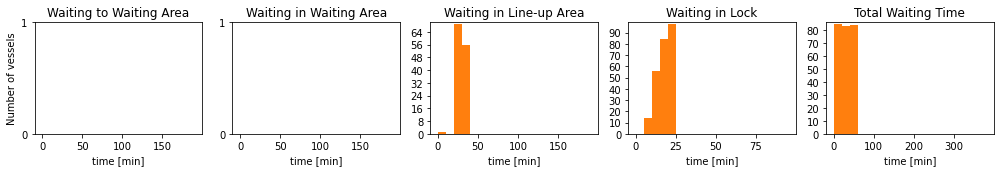

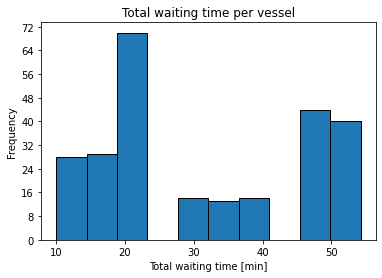

In [20]:
data= [waiting_to_waiting_area,waiting_in_waiting_area,waiting_in_lineup_area,waiting_in_lock,total_waiting_time]
xaxes = 'time [min]'
titles = ['Waiting to Waiting Area','Waiting in Waiting Area','Waiting in Line-up Area','Waiting in Lock','Total Waiting Time'] 
bins = [range(0,200,10),range(0,200,10),range(0,200,10),range(0,100,5),range(0,400,20)]

f,a = plt.subplots(1,5,figsize=(14, 2.5))
a = a.ravel()
for idx,ax in enumerate(a):
    if idx == 0:
        ax.set_ylabel('Number of vessels')
    ax.hist(data[idx], bins = bins[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylim(0, max(ax.hist(data[idx], bins = bins[idx])[0])+1);
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

data = total_waiting_time

fig,ax = plt.subplots(figsize=[6,4])
ax.hist(data,edgecolor='black');
ax.set_title('Total waiting time per vessel')
ax.set_ylabel('Frequency')
ax.set_xlabel('Total waiting time [min]');
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

In [21]:
def color_vessels(vessel,
                  min_linewidth = 0.5,
                  max_linewidth = 3,
                  vessel_database = vessel_db,
                  vessel_norm=mpl.colors.BoundaryNorm(boundaries=list(vessel_db['T_f']),
                                                      ncolors=len(list(vessel_db['T_f'])), 
                                                      extend='max'),
                  vessel_cmap = mpl.colorbar.cm.tab10):

    if str(type(vessel)) == "<class '__main__.Vessel'>":
        for c in enumerate(vessel_cmap.colors[2:(len(list(vessel_db['type']))+2)]):
            if vessel.T_f >= vessel_norm.boundaries[c[0]]:
                color = c[1]
            else:
                break
    else:
        color = []
        for c in enumerate(vessel_cmap.colors[2:(len(list(vessel_db['type']))+2)]):
            color.append(c[1])    
        
    return color

def vessel_legend(axis,
                  vessel_types=list(vessel_db['type']),
                  vessel_draught=list(vessel_db['T_f']),
                  vessel_database = v,
                  vessel_norm=mpl.colors.BoundaryNorm(boundaries=list(vessel_db['T_f']),
                                                      ncolors=len(list(vessel_db['T_f'])), 
                                                      extend='max')):
    colors = color_vessels(vessel_draught)
    for vtype in enumerate(vessel_types):
        axis.plot([0,0],[0,0],
                  color=colors[vtype[0]],
                  label=str(vtype[1]))

    leg= axis.legend(loc='lower left',handlelength=8,ncol=2,bbox_to_anchor=(0.05, -0.25),frameon=False)
    plt.legend(loc='lower left',handlelength=9,ncol=3,bbox_to_anchor=(0.05, -0.215),frameon=False)

def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    
    distance = wgs84.inv(orig[0], orig[1], 
                         dest[0], dest[1])[2]
    
    return distance

vessel_path_x = []
vessel_path_t = []
vessel_colors = []
for v in range(len(vessels)):
    vessel_path_xt = []
    vessel_path_tt = []
    for t in range(0,len(vessels[v].log["Message"])):
        if vessels[v].route[0] == 'Node 1':   
            vessel_path_x0 = (vessels[v].log["Geometry"][0].x,vessels[v].log['Geometry'][0].y)
            vessel_path_t0 = simulation_start.timestamp()
            vessel_path_xt.append(calculate_distance(vessel_path_x0,(vessels[v].log["Geometry"][t].x,vessels[v].log['Geometry'][t].y)))
            vessel_path_tt.append(vessels[v].log["Timestamp"][t].timestamp()-vessel_path_t0)
        if vessels[v].route[0] == 'Node 21':     
            vessel_path_x0 = (vessels[v].log["Geometry"][0].x,vessels[v].log['Geometry'][0].y)
            vessel_path_t0 = simulation_start.timestamp()
            vessel_path_xt.append(calculate_distance((env.FG.nodes[destination]['geometry'].x,env.FG.nodes[destination]['geometry'].y),(env.FG.nodes[origin]['geometry'].x,env.FG.nodes[origin]['geometry'].y))-
                                  calculate_distance(vessel_path_x0,(vessels[v].log["Geometry"][t].x,vessels[v].log['Geometry'][t].y)))
            vessel_path_tt.append(vessels[v].log["Timestamp"][t].timestamp()-vessel_path_t0)
    vessel_path_x.append(vessel_path_xt)
    vessel_path_t.append(vessel_path_tt)
    vessel_colors.append(color_vessels(vessels[v]))

for v in range(0,len(vessels)):
    if vessels[v].route[0] == 'Node 1':   
        vessel_path_x0 = (vessels[v].log["Geometry"][0].x,vessels[v].log['Geometry'][0].y)
        break

In [22]:
df = pd.DataFrame.from_dict(lock_1.log)
df[0:60]
(df['Timestamp'][3]-df['Timestamp'][2]).total_seconds()

300.0

In [23]:
def door_open_time(df,node_inner):
    door_open_times_inner = []
    door_open_times_outer = []
    for i in df.index:
        if i == 0:
            start_time = pd.to_datetime(simulation_start) 
            if i < len(df['Message'])-4:
                end_time = df['Timestamp'][list(df['Message'][i:]).index('Lock doors closing stop')+i]
            else:
                end_time = df['Timestamp'][len(df['Timestamp'])-1]
            if df['Geometry'][i] == node_inner:
                door_open_times_inner.append([(end_time-start_time).total_seconds(),start_time,end_time])
            else:
                door_open_times_outer.append([(end_time-start_time).total_seconds(),start_time,end_time])

        elif df['Message'][i] == 'Lock doors opening start':
            start_time = df['Timestamp'][i]
            if i < len(df['Message'])-4:
                end_time = df['Timestamp'][list(df['Message'][i:]).index('Lock doors closing stop')+i]
            else:
                end_time = df['Timestamp'][len(df['Timestamp'])-1]
            if df['Geometry'][i] == node_inner:
                door_open_times_inner.append([(end_time-start_time).total_seconds(),start_time,end_time])
            else:
                door_open_times_outer.append([(end_time-start_time).total_seconds(),start_time,end_time])
    return door_open_times_inner,door_open_times_outer       
    
door_open_times_inner, door_open_times_outer = door_open_time(df,'Node 12')

In [24]:
def exchange_flux_time_series_calculator(S_lock,S,WLev,Dim_lock,harbour,g = 9.81):
    S_lock_exch = S_lock
    if harbour == 'inner': 
        S_lock_harbour = S.lock_inner
        Wlev_lock_harbour = WLev.lock_inner
        V_lock = Dim_lock.L_lock*Dim_lock.B_lock*(WLev.lock_inner+Dim_lock.h_lock)
    elif harbour == 'outer': 
        S_lock_harbour = S.lock_outer
        Wlev_lock_harbour = WLev.lock_outer
        V_lock = Dim_lock.L_lock*Dim_lock.B_lock*(WLev.lock_outer+Dim_lock.h_lock)
    T_LE = ((2*Dim_lock.L_lock)/(0.5*np.sqrt(g*(0.8*abs(S_lock_harbour-S_lock_exch)/(1000 + 0.8*((S.lock_inner+S.lock_outer)/2)))*(Wlev_lock_harbour+Dim_lock.h_lock))))
    time = np.arange(0,5*T_LE,60)
    Q = [0]
    C = [S_lock_exch]
    for t in enumerate(time):
        if t[0] == 0:
            continue
        delta_t = (t[1]-time[t[0]-1])
        delta_V = V_lock*(np.tanh(t[1]/T_LE)-np.tanh(time[t[0]-1]/T_LE))
        Q.append(delta_V/delta_t)
        M = (S_lock_harbour-S_lock)*delta_V
        S_lock_exch = (S_lock_exch*V_lock+M)/V_lock
        C.append(S_lock_exch)
    fig,[ax1,ax2] = plt.subplots(1,2,figsize=(12, 4))
    ax1.plot(time,Q)
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Discharge [m3/s]')
    ax1.set_title('Exchange discharge lock-harbour over time')
    ax2.plot(time,C)
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Salinity [ppt]')
    ax2.set_title('Salinity of lock chamber over time')

def levelling_to_inner_harbour(S_lock,S,Dim_lock,WLev,V_ship_upstr):
    if WLev.lock_outer < WLev.lock_inner:
        V_levelling = Dim_lock.L_lock*Dim_lock.B_lock*((WLev.lock_inner+Dim_lock.h_lock)-(WLev.lock_outer+Dim_lock.h_lock))
        V_lock_inner = Dim_lock.L_lock*Dim_lock.B_lock*(WLev.lock_inner+Dim_lock.h_lock)
        V_lock_outer = Dim_lock.L_lock*Dim_lock.B_lock*(WLev.lock_outer+Dim_lock.h_lock)
        S_lock = (S_lock*(V_lock_outer-V_ship_upstr)+V_levelling*S.lock_inner)/(V_lock_inner-V_ship_upstr)
        V_loss_lev = 0
    else:
        S_lock = S_lock
        V_loss_lev = Dim_lock.L_lock*Dim_lock.B_lock*((WLev.lock_outer+Dim_lock.h_lock)-(WLev.lock_inner+Dim_lock.h_lock))
    return V_levelling, S_lock, V_loss_lev

def door_opening_inner_harbour(S_lock,S,Dim_lock,WLev,V_ship_upstr,V_ship_downstr,T_door_open,plot=False,g = 9.81):
    V_lock_inner = Dim_lock.L_lock*Dim_lock.B_lock*(WLev.lock_inner+Dim_lock.h_lock)
    M_inner_a = V_ship_upstr*S.lock_inner
    S_lock_a = (S_lock*(V_lock_inner-V_ship_upstr)+M_inner_a)/V_lock_inner
    V_exch_inner = V_lock_inner*np.tanh(T_door_open/(2*Dim_lock.L_lock/(0.5*np.sqrt(g*(0.8*abs(S_lock_a-S.lock_inner)/(1000 + 0.8*((S.lock_inner+S.lock_outer)/2)))*(WLev.lock_inner+Dim_lock.h_lock)))))
    if plot:
        exchange_flux_time_series_calculator(S_lock_a,S,WLev,Dim_lock,'inner',g = 9.81)
    M_inner_b = (S.lock_inner-S_lock_a)*V_exch_inner
    S_lock_b = (S_lock_a*V_lock_inner+M_inner_b)/V_lock_inner
    M_inner_c = -V_ship_downstr*S_lock_b
    M_inner_tot = M_inner_a+M_inner_b+M_inner_c
    S_lock = (S_lock*(V_lock_inner-V_ship_upstr)+M_inner_tot)/(V_lock_inner-V_ship_downstr)
    Q_avg = (V_ship_upstr+V_exch_inner)/T_door_open
    V_loss_exch =  V_ship_upstr-V_ship_downstr
    S_avg = -(M_inner_a+M_inner_b+M_inner_c-(V_ship_upstr+V_exch_inner)*S.lock_inner)/(V_ship_downstr+V_exch_inner)
    return V_exch_inner, -M_inner_b, -M_inner_c, S_lock, Q_avg, S_avg, V_loss_exch

def levelling_to_outer_harbour(S_lock,S,Dim_lock,WLev,V_ship_downstr):
    if WLev.lock_outer > WLev.lock_inner:
        V_levelling = Dim_lock.L_lock*Dim_lock.B_lock*((WLev.lock_outer+Dim_lock.h_lock)-(WLev.lock_inner+Dim_lock.h_lock))
        V_lock_inner = Dim_lock.L_lock*Dim_lock.B_lock*(WLev.lock_inner+Dim_lock.h_lock)
        V_lock_outer = Dim_lock.L_lock*Dim_lock.B_lock*(WLev.lock_outer+Dim_lock.h_lock)
        S_lock = (S_lock*(V_lock_inner-V_ship_downstr)+V_levelling*S.lock_outer)/(V_lock_outer-V_ship_downstr)
        V_loss_lev = 0
    else:
        S_lock = S_lock
        V_loss_lev = Dim_lock.L_lock*Dim_lock.B_lock*((WLev.lock_inner+Dim_lock.h_lock)-(WLev.lock_outer+Dim_lock.h_lock))
    return S_lock, V_loss_lev

def door_opening_outer_harbour(S_lock,S,Dim_lock,WLev,V_ship_upstr,V_ship_downstr,T_open_door,plot=False,g = 9.81):
    V_lock_outer = Dim_lock.L_lock*Dim_lock.B_lock*(WLev.lock_outer+Dim_lock.h_lock)
    M_outer_a = -V_ship_downstr*S.lock_outer
    S_lock_a = (S_lock*(V_lock_outer-V_ship_downstr)-M_outer_a)/V_lock_outer
    V_exch_outer = V_lock_outer*np.tanh(T_door_open/(2*Dim_lock.L_lock/(0.5*np.sqrt(g*(0.8*abs(S.lock_outer-S_lock_a)/(1000 + 0.8*((S.lock_inner+S.lock_outer)/2)))*(WLev.lock_outer+Dim_lock.h_lock)))))
    if plot:
        exchange_flux_time_series_calculator(S_lock_a,S,WLev,Dim_lock,'outer',g = 9.81)
    M_outer_b = V_exch_outer*(S_lock_a - S.lock_outer)
    S_lock_b = (S_lock_a*V_lock_outer - M_outer_b)/V_lock_outer
    M_outer_c = V_ship_upstr*S_lock_b
    M_outer_tot = M_outer_a+M_outer_b+M_outer_c
    S_lock = (S_lock*(V_lock_outer-V_ship_downstr)-M_outer_tot)/(V_lock_outer-V_ship_upstr)
    return S_lock

In [25]:
class lock_dim:
    def __init__(self,L_lock,B_lock,h_lock):
        self.L_lock = L_lock
        self.B_lock = B_lock
        self.h_lock = h_lock
        
class wlev:
    def __init__(self,lock_inner,lock_outer):
        self.lock_inner = lock_inner
        self.lock_outer = lock_outer
        
class salt:
    def __init__(self,lock_inner,lock_outer):
        self.lock_inner = lock_inner
        self.lock_outer = lock_outer
        
Dim_lock = lock_dim(L_lock = 300, B_lock = 25, h_lock = 5)
WLev = wlev(lock_inner = 2, lock_outer = 0)
S = salt(lock_inner = 0, lock_outer = 25)

In [26]:
S_lock = 25
V_ship_upstr = 100*5*20
V_ship_downstr = 100*5*20
T_door_open = 20*60
V_lev,S_lock,V_loss = levelling_to_inner_harbour(S_lock,S,Dim_lock,WLev,V_ship_upstr)
print(V_lev,S_lock)

15000 16.176470588235293


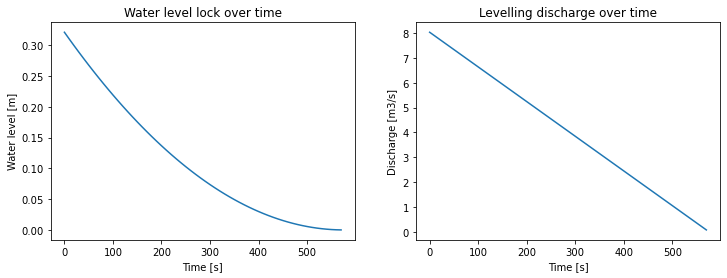

In [27]:
time_index = 31
operation_time = (2*lock_1.lock_length*lock_1.lock_width*np.sqrt(wlev_dif[1][time_index]))/(lock_1.disch_coeff*lock_1.opening_area*np.sqrt(2*9.81))
time = np.arange(0,operation_time,10)
water_level = []
discharge = []
for t in time:
    water_level.append((np.sqrt(wlev_dif[1][time_index])-(lock_1.disch_coeff*lock_1.opening_area*np.sqrt(2*9.81))/(2*lock_1.lock_length*lock_1.lock_width)*t)**2)

for t in enumerate(time):
    discharge.append(lock_1.disch_coeff*lock_1.opening_area*np.sqrt(2*9.81*water_level[t[0]]))
    
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(12, 4))
ax1.plot(time,water_level)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Water level [m]')
ax1.set_title('Water level lock over time')
ax2.plot(time,discharge)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Discharge [m3/s]')
ax2.set_title('Levelling discharge over time')
plt.show()

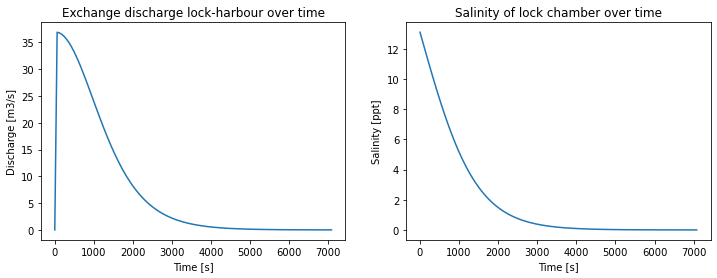

In [28]:
V_exch_inner, M_inner_exch, M_inner_ship, S_lock, Q_avg, S_avg, V_loss = door_opening_inner_harbour(S_lock,S,Dim_lock,WLev,V_ship_upstr,V_ship_downstr,T_door_open,True)

In [29]:
len(FG.nodes)

21

In [30]:
len([500,500,500,500,500,600,500,500,500,24,24,24,500,500,500,600,500,500,500,500])

20

In [31]:
len([5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5])

21

In [32]:
list(FG.nodes)

['Node 1',
 'Node 2',
 'Node 3',
 'Node 4',
 'Node 5',
 'Node 6',
 'Node 7',
 'Node 8',
 'Node 9',
 'Node 10',
 'Node 11',
 'Node 12',
 'Node 13',
 'Node 14',
 'Node 15',
 'Node 16',
 'Node 17',
 'Node 18',
 'Node 19',
 'Node 20',
 'Node 21']

In [33]:
S_lock,V_loss = levelling_to_outer_harbour(S_lock,S,Dim_lock,WLev,V_ship_downstr)

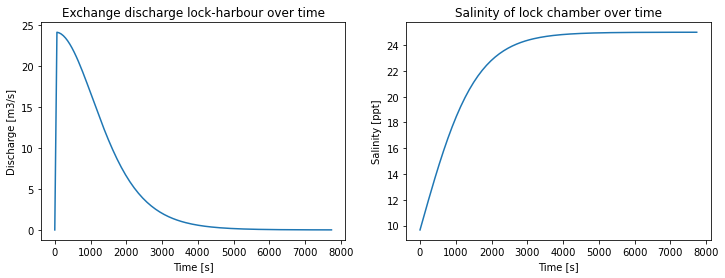

In [34]:
S_lock = door_opening_outer_harbour(S_lock,S,Dim_lock,WLev,V_ship_upstr,V_ship_downstr,T_door_open,True)

In [35]:
def ship_volume_calculation(df,index,vessel_count):
    vessel_indexes = [vessel_count-df['Value'][index],vessel_count]
    V_ship_tot = 0
    for vessel in vessels[vessel_indexes[0]:vessel_indexes[1]]:
        V_ship_tot += vessel.B*vessel.T_f*vessel.L
    return V_ship_tot

Dim_lock = lock_dim(L_lock = lock_1.lock_length, B_lock = lock_1.lock_width, h_lock = lock_1.lock_depth)
WLev = wlev(lock_inner = 2.5, lock_outer = 0)
S = salt(lock_inner = 0, lock_outer = 25)
df = pd.DataFrame.from_dict(lock_1.log)
locking_counter_outer = 0
locking_counter_inner = 0
vessel_count = 0
V_loss_tot = []
M_salt_tot = []
for i in df.index:
    if df['Message'][i] == 'Lock doors closing start':
        if df['Geometry'][i] == 'Node 10':
            T_door_open = door_open_times_outer[locking_counter_outer][0]*60
            if i == 0:
                V_ship_downstr = 0
            else:
                V_ship_downstr = ship_volume_calculation(df,i-1,vessel_count)
            vessel_count += df['Value'][i]
            V_ship_upstr = ship_volume_calculation(df,i,vessel_count)
            locking_counter_outer += 1
            S_lock = door_opening_outer_harbour(S_lock,S,Dim_lock,WLev,V_ship_upstr,V_ship_downstr,T_door_open,plot=False,g = 9.81)   
            V_lev,S_lock,V_loss_lev = levelling_to_inner_harbour(S_lock,S,Dim_lock,WLev,V_ship_upstr)
        elif df['Geometry'][i] == 'Node 12':
            T_door_open = door_open_times_inner[locking_counter_inner][0]*60
            if i == 0:
                V_ship_upstr = 0
            else:
                V_ship_upstr = ship_volume_calculation(df,i-1,vessel_count)
            vessel_count += df['Value'][i]
            V_ship_downstr = ship_volume_calculation(df,i,vessel_count)
            locking_counter_inner += 1
            V_exch_inner, M_inner_exch, M_inner_ship, S_lock, Q_avg, S_avg, V_loss_exch = door_opening_inner_harbour(S_lock,S,Dim_lock,WLev,V_ship_upstr,V_ship_downstr,T_door_open,plot=False,g = 9.81)   
            S_lock,V_loss_lev = levelling_to_outer_harbour(S_lock,S,Dim_lock,WLev,V_ship_upstr)
            V_loss = V_loss_exch+V_loss_lev
            V_loss_tot.append(V_loss)
            M_salt_tot.append(Q_avg*S_avg*T_door_open)

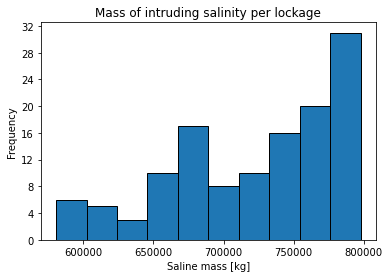

In [36]:
fig,ax = plt.subplots(figsize=[6,4])
ax.hist(M_salt_tot,edgecolor='black');
ax.set_title('Mass of intruding salinity per lockage')
ax.set_ylabel('Frequency')
ax.set_xlabel('Saline mass [kg]');
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

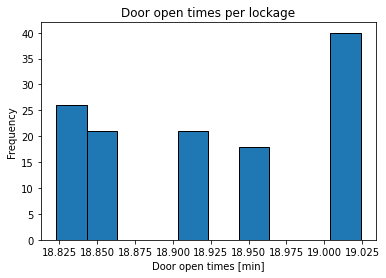

In [37]:
data = [door_open_time[0] for door_open_time in door_open_times_inner]

fig,ax = plt.subplots(figsize=[6,4])
ax.hist([d/60 for d in data],edgecolor='black');
ax.set_title('Door open times per lockage')
ax.set_ylabel('Frequency')
ax.set_xlabel('Door open times [min]');
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

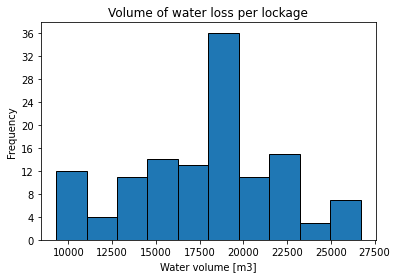

In [38]:
fig,ax = plt.subplots(figsize=[6,4])
ax.hist(V_loss_tot,edgecolor='black');
ax.set_title('Volume of water loss per lockage')
ax.set_ylabel('Frequency')
ax.set_xlabel('Water volume [m3]');
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

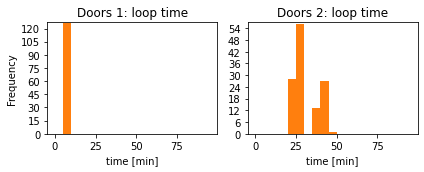

In [39]:
data= [loop_time_doors1,loop_time_doors2]
xaxes = 'time [min]'
titles = ['Doors 1: loop time','Doors 2: loop time'] 
bins = [range(0,100,5),range(0,100,5)]

f,a = plt.subplots(1,2,figsize=(6, 2.5))
a = a.ravel()
for idx,ax in enumerate(a):
    if idx == 0:
        ax.set_ylabel('Frequency')
    ax.hist(data[idx], bins = bins[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylim(0, max(ax.hist(data[idx], bins = bins[idx])[0])+1);
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

In [40]:
def draw_door_open_times(axs,door_open_times_inner,door_open_times_outer,end_time):
    for door_open_times_side in enumerate([door_open_times_outer,door_open_times_inner]):
        axs[door_open_times_side[0]].fill([0,0,1,1],[0,end_time,end_time,0],'indianred')
        for door_open_time in door_open_times_side[1]:
            start_time = (door_open_time[1]-pd.to_datetime(simulation_start)).total_seconds()
            stop_time = start_time+door_open_time[0]
            axs[door_open_times_side[0]].fill([0,0,1,1],[start_time,stop_time,stop_time,start_time],'limegreen')
            if np.mean([start_time,stop_time]) < end_time:
                axs[door_open_times_side[0]].text(0.2,np.mean([start_time,stop_time]),str(round(door_open_time[0]/60)),rotation=90,color='darkgreen',va='center')

In [41]:
def water_level_lock():   
    time_index = np.argmin(abs(wlev_dif[0]-(door_open_times_inner[0][-1]-pd.to_datetime(simulation_start)).total_seconds()))
    operation_time = (2*lock_1.lock_length*lock_1.lock_width*np.sqrt(wlev_dif[1][time_index]))/(lock_1.disch_coeff*lock_1.opening_area*np.sqrt(2*9.81))
    time = np.arange(0,operation_time,10)
    water_level = []
    discharge = []
    for t in time:
        water_level.append((np.sqrt(wlev_dif[1][time_index])-(lock_1.disch_coeff*lock_1.opening_area*np.sqrt(2*9.81))/(2*lock_1.lock_length*lock_1.lock_width)*t)**2)

In [42]:
door_open_times = copy.deepcopy(door_open_times_outer)
door_open_times.extend(door_open_times_inner)
door_open_times_opening = [times[1] for times in door_open_times]
door_open_times_closure = [times[2] for times in door_open_times]
door_open_times = door_open_times_opening
door_open_times.extend(door_open_times_closure)
door_open_times.sort()

In [43]:
# Water level toevoegen aan netwerk/graaf: dit vergt mogelijk een moeilijke iteraire berekening in OpenTNSim (kan in notebook wellicht wel mathematisch berekend worden)
# Tussen levelling moet waterstand waterniveau open kant volgen
# Gemiddeld debiet moet negatief (richting zee) en positief (richting meer)
# Saliniteit in kolk
df

,Message,Timestamp,Value,Geometry
0,Lock doors closing start,2022-08-17 16:19:14.691605,1,Node 10
1,Lock doors closing stop,2022-08-17 16:21:44.691605,1,Node 10
2,Lock chamber converting start,2022-08-17 16:21:44.691605,1,Node 10
3,Lock chamber converting stop,2022-08-17 16:26:44.691605,1,Node 12
4,Lock doors opening start,2022-08-17 16:26:44.691605,1,Node 12
...,...,...,...,...
1507,Lock doors closing stop,2022-08-24 22:28:29.876079,1,Node 12
1508,Lock chamber converting start,2022-08-24 22:28:29.876079,1,Node 12
1509,Lock chamber converting stop,2022-08-24 22:34:29.876079,1,Node 10
1510,Lock doors opening start,2022-08-24 22:34:29.876079,1,Node 10


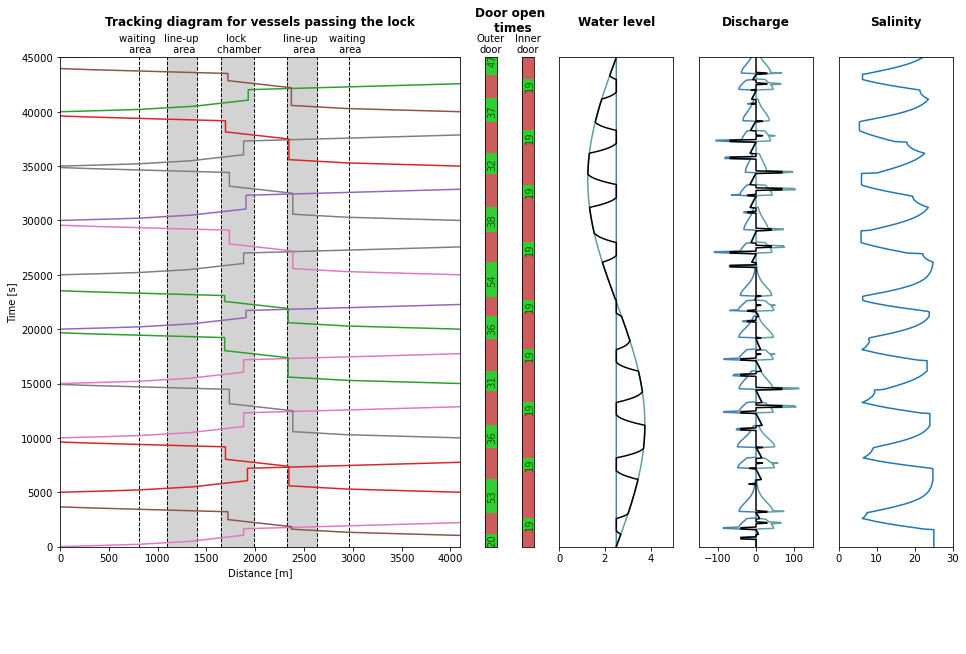

In [44]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6,figsize=(16, 9),gridspec_kw={'width_ratios': [3.5, 0.1, 0.1, 1, 1, 1]})
ax1.patch.set_alpha(0)
ax2.patch.set_alpha(0)
ax3.patch.set_alpha(0)
ax4.patch.set_alpha(0)
manual_ylim = True
ylim = 45000

ax1.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 6"]['geometry'].x,FG.nodes["Node 6"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
ax1.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
ax1.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
ax1.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 10"]['geometry'].x,FG.nodes["Node 10"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
ax1.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 12"]['geometry'].x,FG.nodes["Node 12"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
ax1.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 13"]['geometry'].x,FG.nodes["Node 13"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
ax1.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 14"]['geometry'].x,FG.nodes["Node 14"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
ax1.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 16"]['geometry'].x,FG.nodes["Node 16"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
for v in range(len(vessels)):
    ax1.plot(vessel_path_x[v],vessel_path_t[v],color=vessel_colors[v])

if manual_ylim == False:
    ax1.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 11"]['geometry'].x,FG.nodes["Node 11"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'lock \n chamber',horizontalalignment = 'center')
    ax1.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 14"]['geometry'].x,FG.nodes["Node 14"]['geometry'].y))-
             0.5*calculate_distance((FG.nodes["Node 13"]['geometry'].x,FG.nodes["Node 13"]['geometry'].y),(FG.nodes["Node 14"]['geometry'].x,FG.nodes["Node 14"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'line-up \n area',horizontalalignment = 'center')
    ax1.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y))+
             0.5*calculate_distance((FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y),(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'line-up \n area',horizontalalignment = 'center')
    ax1.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 16"]['geometry'].x,FG.nodes["Node 16"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'waiting \n area',horizontalalignment = 'center')
    ax1.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 6"]['geometry'].x,FG.nodes["Node 6"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'waiting \n area',horizontalalignment = 'center')
else:
    ax1.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 11"]['geometry'].x,FG.nodes["Node 11"]['geometry'].y)),1.01*ylim,'lock \n chamber',horizontalalignment = 'center')
    ax1.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 14"]['geometry'].x,FG.nodes["Node 14"]['geometry'].y))-
             0.5*calculate_distance((FG.nodes["Node 13"]['geometry'].x,FG.nodes["Node 13"]['geometry'].y),(FG.nodes["Node 14"]['geometry'].x,FG.nodes["Node 14"]['geometry'].y)),1.01*ylim,'line-up \n area',horizontalalignment = 'center')
    ax1.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y))+
             0.5*calculate_distance((FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y),(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)),1.01*ylim,'line-up \n area',horizontalalignment = 'center')
    ax1.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 16"]['geometry'].x,FG.nodes["Node 16"]['geometry'].y)),1.01*ylim,'waiting \n area',horizontalalignment = 'center')
    ax1.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 6"]['geometry'].x,FG.nodes["Node 6"]['geometry'].y)),1.01*ylim,'waiting \n area',horizontalalignment = 'center')
    
ax1.set_title("Tracking diagram for vessels passing the lock", fontweight='bold', pad = 32)
ax1.set_xlabel("Distance [m]")
ax1.set_xlim([0,4097.2547273971595])
ax1.set_ylabel("Time [s]")

ax1.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 10"]['geometry'].x,FG.nodes["Node 10"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 10"]['geometry'].x,FG.nodes["Node 10"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 12"]['geometry'].x,FG.nodes["Node 12"]['geometry'].y)), 
          calculate_distance(vessel_path_x0,(FG.nodes["Node 12"]['geometry'].x,FG.nodes["Node 12"]['geometry'].y))],
         [0,ylim, ylim, 0],'lightgrey')

ax1.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 13"]['geometry'].x,FG.nodes["Node 13"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 13"]['geometry'].x,FG.nodes["Node 13"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 14"]['geometry'].x,FG.nodes["Node 14"]['geometry'].y)), 
          calculate_distance(vessel_path_x0,(FG.nodes["Node 14"]['geometry'].x,FG.nodes["Node 14"]['geometry'].y))],
         [0,ylim, ylim, 0],'lightgrey')

ax1.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)), 
          calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y))],
         [0,ylim, ylim, 0],'lightgrey')

vessel_types = list(vessel_db['type'])
vessel_legend(ax,vessel_types)

ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
ax3.xaxis.set_visible(False)
draw_door_open_times([ax2,ax3],door_open_times_inner,door_open_times_outer,ylim)
if manual_ylim == False:
    ax1.set_ylim([0,ax.get_ylim()[1]])
    ax2.set_ylim([0,ax.get_ylim()[1]])
    ax3.set_ylim([0,ax.get_ylim()[1]])
    ax4.set_ylim([0,ax.get_ylim()[1]])
    ax5.set_ylim([0,ax.get_ylim()[1]])
    ax6.set_ylim([0,ax.get_ylim()[1]])
else:
    ax1.set_ylim([0,ylim])
    ax2.set_ylim([0,ylim])
    ax3.set_ylim([0,ylim])
    ax4.set_ylim([0,ylim])
    ax5.set_ylim([0,ylim])
    ax6.set_ylim([0,ylim])
ax2.set_xlim([0,1])
ax3.set_xlim([0,1])
ax2.set_title("Door open\n times", fontweight='bold', position = [2.2,2.2],pad=26)
ax2.text(0.5,1.01*ylim,'Outer\ndoor',horizontalalignment  = 'center')
ax3.text(0.5,1.01*ylim,'Inner\ndoor',horizontalalignment  = 'center')

ax4.yaxis.set_visible(False)
ax4.set_title("Water level", fontweight='bold', pad = 32)
ax4.set_xlim([0,5])
ax4.plot(FG.nodes['Node 10']['Info']['Water level'],[time-simulation_start.timestamp() for time in FG.nodes['Node 10']['Info']['Times']],color='cadetblue')
ax4.plot(FG.nodes['Node 12']['Info']['Water level'],[time-simulation_start.timestamp() for time in FG.nodes['Node 12']['Info']['Times']],color='steelblue')
ax4.plot(FG.nodes['Node 11']['Info']['Water level'],[time-simulation_start.timestamp() for time in FG.nodes['Node 11']['Info']['Times']],'k')

ax5.yaxis.set_visible(False)
ax5.plot(FG.nodes['Node 11']['Lock'][0].discharge_saline,[time-simulation_start.timestamp() for time in FG.nodes['Node 11']['Info']['Times']],color='cadetblue')
ax5.plot(FG.nodes['Node 11']['Lock'][0].discharge_fresh,[time-simulation_start.timestamp() for time in FG.nodes['Node 11']['Info']['Times']],color='steelblue')
ax5.plot(FG.nodes['Node 11']['Lock'][0].discharge_res,[time-simulation_start.timestamp() for time in FG.nodes['Node 11']['Info']['Times']],'k')
ax5.set_title("Discharge", fontweight='bold', pad = 32)
ax5.set_xlim([-150,150])

ax6.yaxis.set_visible(False)
ax6.plot(FG.nodes['Node 11']['Info']['Salinity'],[time-simulation_start.timestamp() for time in FG.nodes['Node 10']['Info']['Times']])
ax6.set_title("Salinity", fontweight='bold', pad = 32)
ax6.set_xlim([0,30])

plt.show()
extent = fig.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('lockages.png', dpi=300,bbox_inches=extent.expanded(1.0, 1.2));